# ASVspoof5 Train-Only Probe (B -> C): Bonafide vs Spoof

This notebook trains a `StandardScaler + LogisticRegression` probe on **ReDimNet embeddings** using the ASVspoof5 train-only subset with the fixed speaker split:

- Train: `group B` (15 speakers)
- Test: `group C` (5 speakers)
- Labels: `0=bonafide`, `1=spoof`

This is the clean baseline probe for the train-only subset.


In [3]:
import json
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchaudio
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")
MANIFEST_PATH = PROJECT_ROOT / "redimnet" / "tcav" / "deepfakes" / "asvspoof5" / "asvspoof5_train_only_selected_utterances_plan.csv"
SUBSET_AUDIO_ROOT = PROJECT_ROOT / "data" / "datasets" / "asvspoof5_train_only_subset_audio"

EMBED_CACHE_DIR = PROJECT_ROOT / "data" / "embeddings" / "asvspoof5_train_only_abc"
EMBED_CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("DEVICE:", DEVICE)
print("MANIFEST_PATH:", MANIFEST_PATH)
print("SUBSET_AUDIO_ROOT:", SUBSET_AUDIO_ROOT)

OUT_DIR = PROJECT_ROOT / 'data' / 'models' / 'asvspoof5_train_only_probe_BC_global'
OUT_DIR.mkdir(parents=True, exist_ok=True)
CACHE_NPZ = EMBED_CACHE_DIR / 'embeddings_BC_global.npz'
FORCE_RECOMPUTE_EMBEDDINGS = False


DEVICE: cuda
MANIFEST_PATH: /home/SpeakerRec/BioVoice/redimnet/tcav/deepfakes/asvspoof5/asvspoof5_train_only_selected_utterances_plan.csv
SUBSET_AUDIO_ROOT: /home/SpeakerRec/BioVoice/data/datasets/asvspoof5_train_only_subset_audio


In [5]:
LABEL_MAP = {"bonafide": 0, "spoof": 1}


def build_audio_path(row, subset_root: Path) -> Path:
    # extracted subset layout: <root>/<group>/<label>/<utt_id>.flac
    return subset_root / str(row["group"]) / str(row["label"]) / f"{row['utt_id']}.flac"


def load_manifest(manifest_path: Path, subset_root: Path) -> pd.DataFrame:
    df = pd.read_csv(manifest_path)
    req = {"group", "speaker_id", "utt_id", "label", "system_id"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Manifest missing columns: {sorted(missing)}")

    df = df.copy()
    df["label_str"] = df["label"].astype(str)
    df["label_id"] = df["label_str"].map(LABEL_MAP).astype(int)
    df["audio_path"] = df.apply(lambda r: str(build_audio_path(r, subset_root)), axis=1)
    df["audio_exists"] = df["audio_path"].map(lambda p: Path(p).exists())
    return df


def embed_with_redim(model, wav_path: str, device: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]
    wav = wav.to(device)
    with torch.no_grad():
        emb = model(wav)
    return emb.squeeze(0).detach().cpu().numpy().astype(np.float32)


def extract_embeddings_for_df(df: pd.DataFrame, model, device: str, cache_npz: Path, force_recompute: bool = False):
    if cache_npz.exists() and not force_recompute:
        payload = np.load(cache_npz, allow_pickle=True)
        emb = payload["X"]
        utt_ids = payload["utt_ids"].astype(str)
        cache_df = pd.DataFrame({"utt_id": utt_ids, "_emb_idx": np.arange(len(utt_ids))})
        merged = df.merge(cache_df, on="utt_id", how="left", validate="one_to_one")
        if merged["_emb_idx"].isna().any():
            missing = merged.loc[merged["_emb_idx"].isna(), "utt_id"].tolist()[:10]
            raise RuntimeError(f"Cache missing utt_ids, examples: {missing}")
        X = emb[merged["_emb_idx"].astype(int).to_numpy()]
        return X

    rows = []
    vecs = []
    for rec in tqdm(df.to_dict("records"), desc=f"Embedding {len(df)} samples"):
        p = Path(rec["audio_path"])
        if not p.exists():
            raise FileNotFoundError(f"Missing audio: {p}")
        vecs.append(embed_with_redim(model, str(p), device))
        rows.append(str(rec["utt_id"]))
    X = np.stack(vecs).astype(np.float32)
    np.savez_compressed(cache_npz, X=X, utt_ids=np.array(rows, dtype=object))
    return X


def train_and_eval_logreg(X_train, y_train, X_test, y_test, class_weight="balanced"):
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    clf = LogisticRegression(max_iter=2000, class_weight=class_weight, random_state=42)
    clf.fit(X_train_s, y_train)

    p_train = clf.predict_proba(X_train_s)[:, 1]
    p_test = clf.predict_proba(X_test_s)[:, 1]
    yhat_train = (p_train >= 0.5).astype(int)
    yhat_test = (p_test >= 0.5).astype(int)

    metrics = {
        "train_accuracy": float(accuracy_score(y_train, yhat_train)),
        "test_accuracy": float(accuracy_score(y_test, yhat_test)),
        "train_auc": float(roc_auc_score(y_train, p_train)) if len(np.unique(y_train)) == 2 else None,
        "test_auc": float(roc_auc_score(y_test, p_test)) if len(np.unique(y_test)) == 2 else None,
        "train_confusion_matrix": confusion_matrix(y_train, yhat_train).tolist(),
        "test_confusion_matrix": confusion_matrix(y_test, yhat_test).tolist(),
        "train_classification_report": classification_report(y_train, yhat_train, output_dict=True, zero_division=0),
        "test_classification_report": classification_report(y_test, yhat_test, output_dict=True, zero_division=0),
    }
    return scaler, clf, X_train_s, X_test_s, p_train, p_test, yhat_train, yhat_test, metrics


def plot_confmat(cm, title):
    fig, ax = plt.subplots(figsize=(4,4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["bonafide","spoof"], rotation=30, ha="right")
    ax.set_yticklabels(["bonafide","spoof"])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.colorbar(im, ax=ax, fraction=0.046)
    plt.tight_layout()
    return fig


In [6]:
# Load ReDimNet backbone for embedding extraction
redim_model = (
    torch.hub.load(
        "IDRnD/ReDimNet",
        "ReDimNet",
        model_name="b5",
        train_type="ptn",
        dataset="vox2",
    )
    .to(DEVICE)
    .eval()
)
print("Loaded ReDimNet on", DEVICE)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet on cuda


In [7]:
# Load manifest and build B/C split
manifest_df = load_manifest(MANIFEST_PATH, SUBSET_AUDIO_ROOT)
print("Manifest rows:", len(manifest_df))
print("Missing audio paths:", int((~manifest_df['audio_exists']).sum()))

bc_df = manifest_df[manifest_df['group'].isin(['B','C'])].copy().reset_index(drop=True)
print("B/C rows:", len(bc_df))
print(bc_df.groupby(['group','label_str']).size().unstack(fill_value=0))
print("Unique B speakers:", bc_df.loc[bc_df.group=='B','speaker_id'].nunique())
print("Unique C speakers:", bc_df.loc[bc_df.group=='C','speaker_id'].nunique())

X_bc = extract_embeddings_for_df(bc_df[['utt_id','audio_path']], redim_model, DEVICE, CACHE_NPZ, force_recompute=FORCE_RECOMPUTE_EMBEDDINGS)
y_bc = bc_df['label_id'].to_numpy().astype(int)

train_mask = bc_df['group'].eq('B').to_numpy()
test_mask = bc_df['group'].eq('C').to_numpy()

X_train, y_train = X_bc[train_mask], y_bc[train_mask]
X_test, y_test = X_bc[test_mask], y_bc[test_mask]
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Manifest rows: 3200
Missing audio paths: 0
B/C rows: 1280
label_str  bonafide  spoof
group                     
B               480    480
C               160    160
Unique B speakers: 15
Unique C speakers: 5


Embedding 1280 samples: 100%|██████████| 1280/1280 [02:14<00:00,  9.54it/s]

Train shape: (960, 192) Test shape: (320, 192)


In [8]:
scaler, clf, X_train_s, X_test_s, p_train, p_test, yhat_train, yhat_test, metrics = train_and_eval_logreg(
    X_train, y_train, X_test, y_test, class_weight='balanced'
)

print(json.dumps({k:v for k,v in metrics.items() if 'report' not in k}, indent=2))


{
  "train_accuracy": 1.0,
  "test_accuracy": 0.821875,
  "train_auc": 1.0,
  "test_auc": 0.9606250000000001,
  "train_confusion_matrix": [
    [
      480,
      0
    ],
    [
      0,
      480
    ]
  ],
  "test_confusion_matrix": [
    [
      110,
      50
    ],
    [
      7,
      153
    ]
  ]
}


In [9]:
# Save model + metrics + predictions
with open(OUT_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open(OUT_DIR / 'logistic_regression.pkl', 'wb') as f:
    pickle.dump(clf, f)
(OUT_DIR / 'metrics.json').write_text(json.dumps(metrics, indent=2), encoding='utf-8')

pred_df = bc_df[['group','speaker_id','utt_id','label_str','label_id','system_id']].copy()
pred_df['split'] = np.where(train_mask, 'train_B', 'test_C')
pred_df['prob_spoof'] = np.concatenate([p_train, p_test])
pred_df['pred_label_id'] = np.concatenate([yhat_train, yhat_test])
pred_df['pred_label_str'] = pred_df['pred_label_id'].map({0:'bonafide',1:'spoof'})
pred_df.to_csv(OUT_DIR / 'predictions_BC_global.csv', index=False)

coef_df = pd.DataFrame({
    'feature_index': np.arange(clf.coef_.shape[1]),
    'coefficient': clf.coef_.ravel(),
    'abs_coefficient': np.abs(clf.coef_.ravel()),
}).sort_values('abs_coefficient', ascending=False)
coef_df.to_csv(OUT_DIR / 'coefficients.csv', index=False)

print('Saved outputs ->', OUT_DIR)


Saved outputs -> /home/SpeakerRec/BioVoice/data/models/asvspoof5_train_only_probe_BC_global


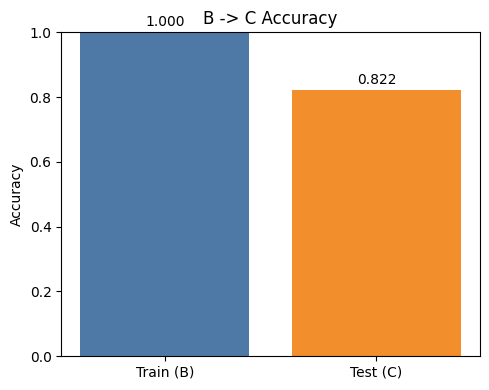

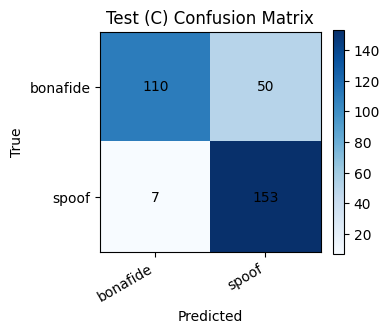

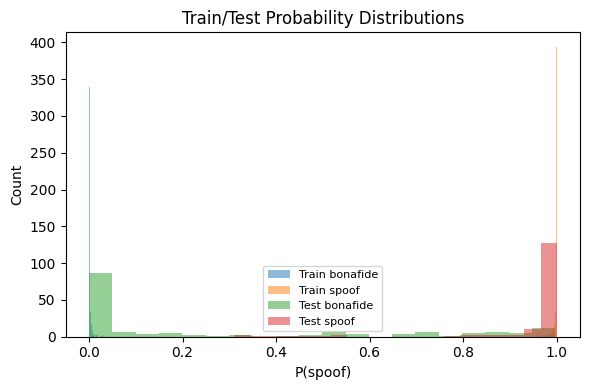

In [10]:
# Plots: train/test accuracy + confusion matrix + probability histograms
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(['Train (B)','Test (C)'], [metrics['train_accuracy'], metrics['test_accuracy']], color=['#4e79a7','#f28e2b'])
ax.set_ylim(0,1)
ax.set_ylabel('Accuracy')
ax.set_title('B -> C Accuracy')
for i,v in enumerate([metrics['train_accuracy'], metrics['test_accuracy']]):
    ax.text(i, v+0.02, f'{v:.3f}', ha='center')
plt.tight_layout(); plt.show()

cm_fig = plot_confmat(np.array(metrics['test_confusion_matrix']), 'Test (C) Confusion Matrix')
plt.show()

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(p_train[y_train==0], bins=20, alpha=0.5, label='Train bonafide')
ax.hist(p_train[y_train==1], bins=20, alpha=0.5, label='Train spoof')
ax.hist(p_test[y_test==0], bins=20, alpha=0.5, label='Test bonafide')
ax.hist(p_test[y_test==1], bins=20, alpha=0.5, label='Test spoof')
ax.set_xlabel('P(spoof)')
ax.set_ylabel('Count')
ax.set_title('Train/Test Probability Distributions')
ax.legend(fontsize=8)
plt.tight_layout(); plt.show()
